In [1]:
from sympy import simplify, parse_expr
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from flash_ansr import SkeletonPool, get_path
from flash_ansr.expressions.utils import num_to_constants, numbers_to_num
from flash_ansr.eval.utils import bootstrapped_metric_ci
import time
import pickle

In [2]:
pool = SkeletonPool.from_config(get_path('configs', 'v7.20', 'skeleton_pool_val.yaml'))
pool.sample_strategy['max_operators'] = 15
pool.sample_strategy['max_length'] = 2 * 15 + 1
pool.sample_strategy['max_tries'] = 100
pool.simplify = False

Compiling Skeletons: 100%|██████████| 4999/4999 [00:00<00:00, 27971.17it/s]


In [3]:
N_SAMPLES = 10_000

In [4]:
simplified_skeletons = {}
simplification_times = {}

pbar = tqdm(total=N_SAMPLES, smoothing=0)
while len(simplified_skeletons) < N_SAMPLES:
    skeleton, _, _ = pool.sample_skeleton()

    if skeleton in simplified_skeletons:
        continue
    # pbar.set_postfix_str(f'{len(skeleton)}: {skeleton}')

    try:
        auto_time1 = time.time()
        auto_simplified = pool.expression_space.simplify(skeleton, max_iter=5)
        auto_time2 = time.time()

        simplified_skeletons[skeleton] = {
            'auto': auto_simplified,
        }
        simplification_times[skeleton] = {
            'auto': auto_time2 - auto_time1,
        }

    except (IndexError, ValueError):
        continue

    pbar.update(1)

pbar.close()

100%|██████████| 10000/10000 [00:14<00:00, 668.21it/s]


In [5]:
min_length, max_length = np.inf, -np.inf
for k, v in simplified_skeletons.items():
    min_length = np.min([min_length, len(k)] + [len(vi) for vi in v.values() if vi is not None])
    max_length = np.max([max_length, len(k)] + [len(vi) for vi in v.values() if vi is not None])

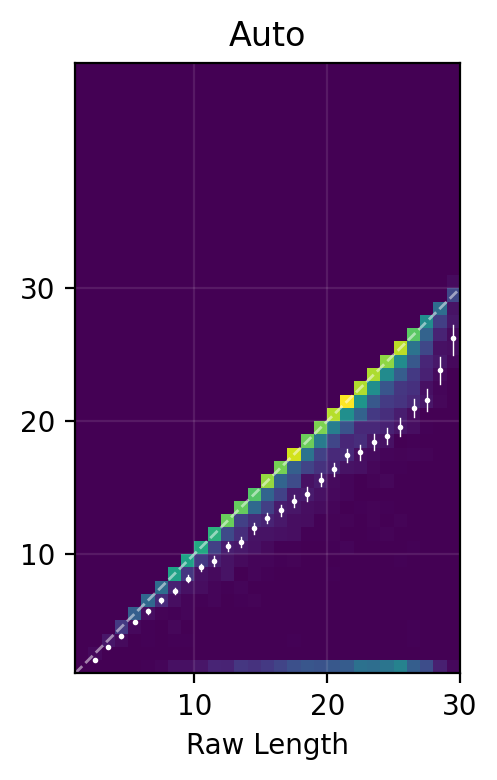

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(9, 4), dpi=200)

axes = np.atleast_1d(axes)

raw_bins = np.arange(min_length, 31)
simplified_bins = np.arange(min_length, 48)

vmin, vmax = np.inf, -np.inf

for method in ['auto']:
    original_lengths = np.array([len(k) for k in simplified_skeletons.keys()])
    simplified_lengths = np.array([np.nan if v[method] is None else len(v[method]) for v in simplified_skeletons.values()])
    valid_mask = ~np.isnan(simplified_lengths)
    h = np.histogram2d(original_lengths[valid_mask], simplified_lengths[valid_mask], bins=[raw_bins, simplified_bins]);
    vmin = min(vmin, h[0].min())
    vmax = max(vmax, h[0].max())

for ax, method, name in zip(axes, ['auto'], ['Auto']):
    original_lengths = np.array([len(k) for k in simplified_skeletons.keys()])
    simplified_lengths = np.array([np.nan if v[method] is None else len(v[method]) for v in simplified_skeletons.values()])
    valid_mask = ~np.isnan(simplified_lengths)

    ax.hist2d(original_lengths[valid_mask], simplified_lengths[valid_mask], bins=[raw_bins, simplified_bins], cmap='viridis', vmin=vmin, vmax=vmax, linewidth=0, rasterized=True);
    ax.set_xlabel('Raw Length')
    if method == 'custom':
        ax.set_ylabel(f'Simplified Length\n$\\leftarrow$')
    ax.set_title(name)
    ax.grid(color='white', alpha=0.1)
    # ax.set_aspect('equal', adjustable='box')

    ax.set_xticks(np.arange(0, max_length + 1, 10))
    ax.set_yticks(np.arange(0, max_length + 1, 10))

    ax.set_facecolor(plt.get_cmap('viridis')(0))

    ax.set_xlim(*raw_bins[[0, -1]])
    ax.set_ylim(*simplified_bins[[0, -1]])

    # Equal aspect ratio
    ax.set_aspect('equal', adjustable='box')

    # Draw a line that shows the median simplified length for each raw length
    x_list = []
    y_list = []
    y_upper_list = []
    y_lower_list = []
    for i in range(len(raw_bins) - 1):
        raw_mask = (original_lengths >= raw_bins[i]) & (original_lengths < raw_bins[i + 1])
        if np.any(raw_mask):
            statistic, lower, upper = bootstrapped_metric_ci(simplified_lengths[raw_mask], np.nanmean)
            x_list.append((raw_bins[i] + raw_bins[i + 1]) / 2)
            y_list.append(statistic)
            y_upper_list.append(upper)
            y_lower_list.append(lower)
    ax.scatter(x_list, y_list, color='w', s=1)
    for x, y, y_upper, y_lower in zip(x_list, y_list, y_upper_list, y_lower_list):
        ax.plot([x, x], [y_lower, y_upper], color='w', lw=0.5)
    # Draw a diagonal
    ax.plot([1, max_length], [1, max_length], color='white', lw=1, ls='--', alpha=0.5)

# # Show the flash.png image next to the ANSR header
# flash = plt.imread(get_path('assets', 'flash.png'))

# # Create a new image with the flash.png image
# # Apparently there is no feasable way to write emojis in matplotlib WTF?!
# ax_image = fig.add_axes([0.195, 0.925, 0.04, 0.04], anchor='NE', zorder=10)
# ax_image.imshow(flash)
# ax_image.axis('off')

fig.tight_layout(w_pad=-8)
# plt.savefig(get_path('results', 'simplification', filename='length_custom_vs_sympy_10k_unique.svg', create=True), bbox_inches='tight')

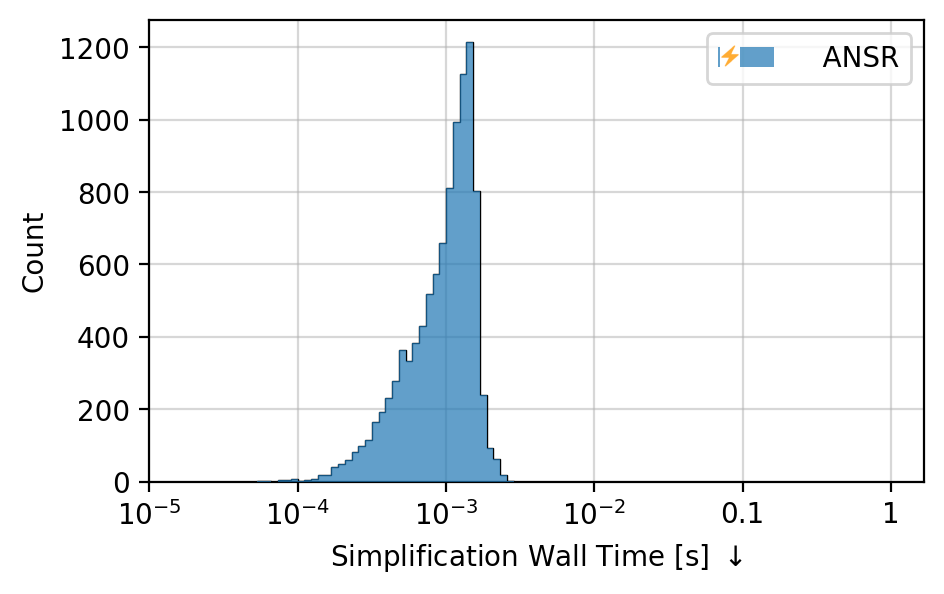

In [7]:
# Show simplification times
auto_times = np.array([v['auto'] for v in simplification_times.values()])

fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)

bins=np.linspace(-4.5, 0, 100)

ax.hist(np.log10(auto_times), bins=bins, alpha=0.7, label='   ANSR', color='tab:blue', zorder=3, linewidth=0, rasterized=True);

# Same thing but only outline
ax.hist(np.log10(auto_times), bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)


# Show the flash.png image next to the ANSR header
flash = plt.imread(get_path('assets', 'flash.png'))

# Create a new image with the flash.png image
# Apparently there is no feasable way to write emojis in matplotlib WTF?!
ax_image = fig.add_axes([0.675, 0.80, 0.04, 0.04], anchor='NE', zorder=10)
ax_image.imshow(flash)
ax_image.axis('off')


ax.set_xticks(np.arange(-5, 1))
labels = [f'$10^{{{i}}}$' for i in np.arange(-5, 1)]
labels[-2] = '0.1'
labels[-1] = '1'
ax.set_xticklabels(labels)

ax.set_xlabel('Simplification Wall Time [s] $ \\downarrow $')
ax.set_ylabel('Count')
ax.legend();
ax.grid(alpha=0.5, zorder=0)
# plt.savefig(get_path('results', 'simplification', filename='simplification_times_auto_vs_sympy_10k_unique.svg', create=True), bbox_inches='tight')